Teamgold

In [22]:
# imports & parquet dateien einlesen
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_info = pd.read_parquet("../filtered_data/match_info.parquet")
df_general = pd.read_parquet("../filtered_data/match_player_general.parquet")
df_ts = pd.read_parquet("../filtered_data/match_player_timestamp.parquet")

End of Game Winning TeamGold Advantage

In [23]:
# Teamgold berechnen

team_gold = (
    df_general.groupby(["match_id", "team"])["net_worth"]
    .sum()
    .reset_index()
)

team_gold_wide = team_gold.pivot(
    index="match_id",
    columns="team",
    values="net_worth"
).reset_index()

# +wert team0 goldlead, -wert team1 goldvorteil
team_gold_wide["Team0"] = team_gold_wide["Team0"].astype("int64")
team_gold_wide["Team1"] = team_gold_wide["Team1"].astype("int64")
team_gold_wide["gold_diff"] = team_gold_wide["Team0"] - team_gold_wide["Team1"]

# add winner
merged = team_gold_wide.merge(
    df_info[["match_id", "winning_team"]],
    on="match_id",
    how="left"
)

# team with goldlead
merged["team_with_more_gold"] = merged["gold_diff"].apply(
    lambda x: "Team0" if x > 0 else "Team1"
)

merged["gold_advantage_winner"] = (
    merged["team_with_more_gold"] == merged["winning_team"]
)

# accuracy goldlead/winner
acc = merged["gold_advantage_winner"].mean()
print("Goldleader gewinnt (Accuracy):", acc)

# winner != goldlead
comebacks = merged[~merged["gold_advantage_winner"]].copy()

print("\nAnzahl Spiele, in denen Sieger keinen Goldlead hatte:", len(comebacks))

# match_id comebacks
print(
    comebacks[["match_id", "Team0", "Team1", "gold_diff", "team_with_more_gold", "winning_team"]]
    .sort_values("gold_diff")
    .to_string(index=False)
)


Goldleader gewinnt (Accuracy): 0.9728839972728158

Anzahl Spiele, in denen Sieger keinen Goldlead hatte: 1392
 match_id  Team0  Team1  gold_diff team_with_more_gold winning_team
 45570783 210334 267426     -57092               Team1        Team0
 44744483 208400 264730     -56330               Team1        Team0
 44727044 309648 361075     -51427               Team1        Team0
 45661378 283533 331550     -48017               Team1        Team0
 45500006 502600 549589     -46989               Team1        Team0
 44489847 280784 327197     -46413               Team1        Team0
 45111508 198515 242205     -43690               Team1        Team0
 45209905 252619 293266     -40647               Team1        Team0
 45701577 242264 278437     -36173               Team1        Team0
 44708339 244897 279006     -34109               Team1        Team0
 45382277 264667 298765     -34098               Team1        Team0
 45555453 241215 273882     -32667               Team1        Team0
 45340

PLOT Häufigkeit von Goldlead-Siegen & Comebacks

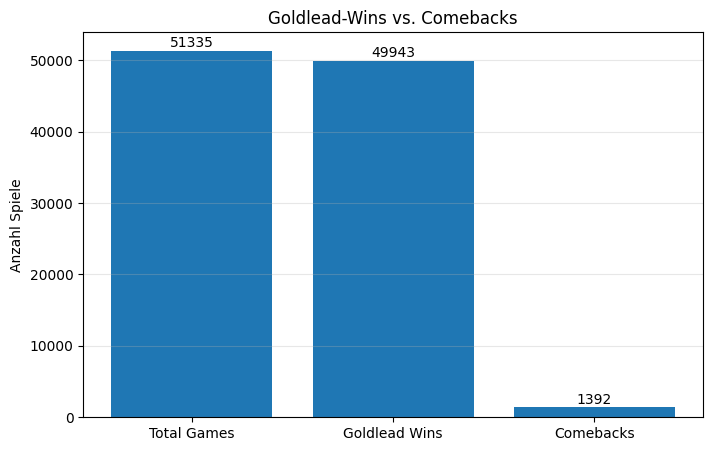

In [24]:
# Gesamtspiele
total_games = len(merged)

# Spiele, bei denen Goldleader gewonnen hat
goldlead_wins = merged["gold_advantage_winner"].sum()

# Comebacks: Goldleader hat NICHT gewonnen
comeback_games = total_games - goldlead_wins

# Plot
plt.figure(figsize=(8, 5))

labels = ["Total Games", "Goldlead Wins", "Comebacks"]
values = [total_games, goldlead_wins, comeback_games]

plt.bar(labels, values)

plt.title("Goldlead-Wins vs. Comebacks")
plt.ylabel("Anzahl Spiele")
plt.grid(axis="y", alpha=0.3)

# Zahlen über die Balken schreiben
for i, v in enumerate(values):
    plt.text(i, v + (total_games * 0.01), str(v), ha='center', fontsize=10)

plt.show()

Gewinn-Golddifferenz

In [25]:
# golddifferenz für das gewinnende Team berechnen
merged["winner_gold_diff"] = merged.apply(
    lambda row: row["gold_diff"] if row["winning_team"] == "Team0" else -row["gold_diff"],
    axis=1
)
winner_golds = merged["winner_gold_diff"]

avg_gold = winner_golds.mean()
max_gold = winner_golds.max()

print("Durchschnittliche Golddifferenz (Gewinner):", avg_gold)
print("Maximale Golddifferenz (Gewinner):", max_gold)

comeback_golds = merged[merged["winner_gold_diff"] < 0]["winner_gold_diff"]

print("Anzahl Comebacks:", len(comeback_golds))
if len(comeback_golds) > 0:
    print("Größtes Comeback (maximaler negativer Goldvorteil):", comeback_golds.min())
    print("Durchschnittlicher Goldnachteil bei Comebacks:", comeback_golds.mean())



Durchschnittliche Golddifferenz (Gewinner): 33933.57115028733
Maximale Golddifferenz (Gewinner): 96386
Anzahl Comebacks: 1392
Größtes Comeback (maximaler negativer Goldvorteil): -57092
Durchschnittlicher Goldnachteil bei Comebacks: -8859.770833333334


PLOT MIN/MAX/AVG GOLD

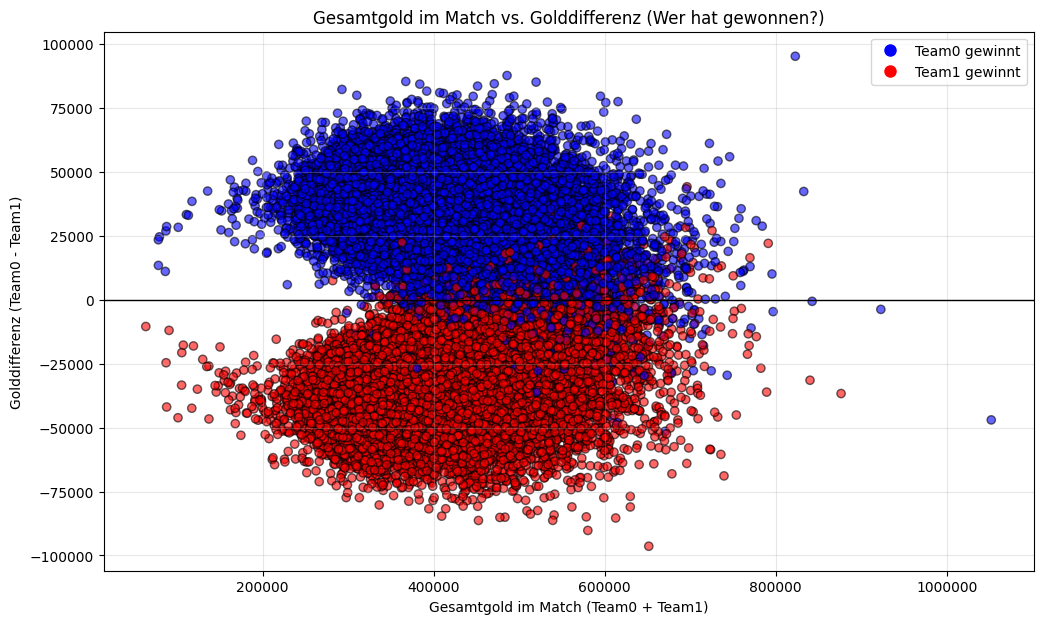

In [26]:
# calc gold
team_gold_wide["total_gold"] = team_gold_wide["Team0"] + team_gold_wide["Team1"]

merged_extended = merged.merge(
    team_gold_wide[["match_id", "total_gold"]],
    on="match_id",
    how="left"
)

plt.figure(figsize=(12, 7))

# Scatterplot
scatter = plt.scatter(
    merged_extended["total_gold"],
    merged_extended["gold_diff"],
    c=merged_extended["winning_team"].map({"Team0": 0, "Team1": 1}),
    cmap="bwr",        # blau = Team0, rot = Team1
    alpha=0.6,
    edgecolors="k"
)

plt.ticklabel_format(style='plain', axis='x')
plt.axhline(0, color="black", linewidth=1)  # Trennt Goldlead

plt.title("Gesamtgold im Match vs. Golddifferenz (Wer hat gewonnen?)")
plt.xlabel("Gesamtgold im Match (Team0 + Team1)")
plt.ylabel("Golddifferenz (Team0 - Team1)")

# Legende
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Team0 gewinnt', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Team1 gewinnt', markerfacecolor='red', markersize=10)
]
plt.legend(handles=handles)

plt.grid(alpha=0.3)

plt.show()

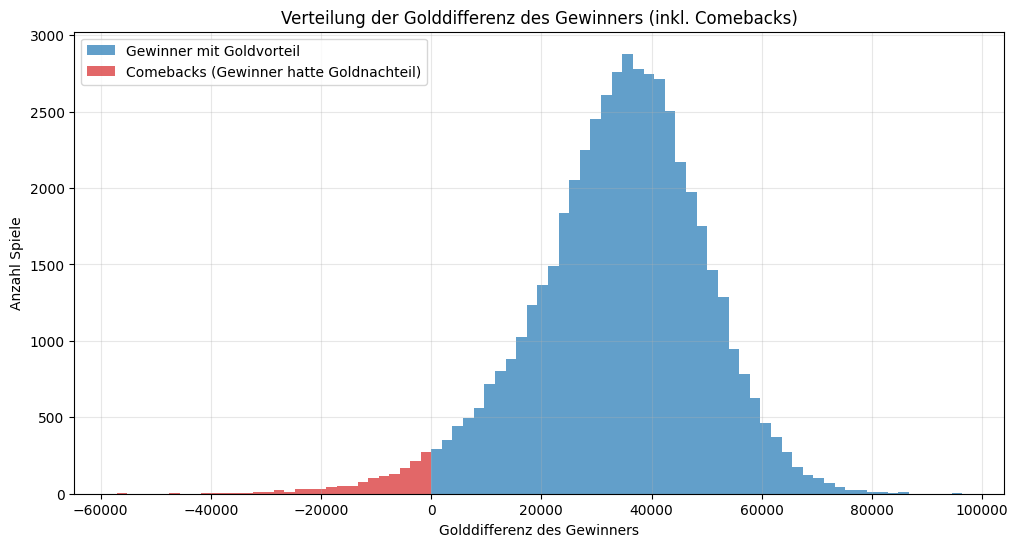

In [27]:
winner_golds = merged["winner_gold_diff"]
comeback_golds = merged[merged["winner_gold_diff"] < 0]["winner_gold_diff"]
normal_wins = merged[merged["winner_gold_diff"] >= 0]["winner_gold_diff"]
plt.figure(figsize=(12, 6))
# Histogramm der Gewinner-Gold-Differenzen
plt.hist( normal_wins, bins=50, alpha=0.7, label="Gewinner mit Goldvorteil", color="tab:blue" )
# Histogramm der Comebacks (negativ) 
if len(comeback_golds) > 0: 
    plt.hist( comeback_golds, 
             bins=30, alpha=0.7, 
             label="Comebacks (Gewinner hatte Goldnachteil)", 
             color="tab:red" )


plt.title("Verteilung der Golddifferenz des Gewinners (inkl. Comebacks)")
plt.xlabel("Golddifferenz des Gewinners") 
plt.ylabel("Anzahl Spiele") 
plt.legend()
plt.grid(alpha=0.3)

plt.show()

Golddiffenenz zum Zeitpunkt X

In [28]:
player_team = df_general[["match_id", "account_id", "team"]].drop_duplicates()

df_ts_team = df_ts.merge(
    player_team,
    on=["match_id", "account_id"],
    how="left"
)

# durchschnittsgold pro timestamp + team
team_gold_ts = (
    df_ts_team.groupby(["match_id", "timestamp_s", "team"])["net_worth"]
    .mean()
    .reset_index()
)

#(Team0 / Team1)
team_gold_ts_wide = team_gold_ts.pivot(
    index=["match_id", "timestamp_s"],
    columns="team",
    values="net_worth"
).reset_index()

# golddifferenz (positiv = Team0, negativ = Team1)
team_gold_ts_wide["Team0"] = team_gold_ts_wide["Team0"].astype("int64")
team_gold_ts_wide["Team1"] = team_gold_ts_wide["Team1"].astype("int64")
team_gold_ts_wide["gold_diff"] = team_gold_ts_wide["Team0"] - team_gold_ts_wide["Team1"]

# add winningteam
gold_ts = team_gold_ts_wide.merge(
    df_info[["match_id", "winning_team"]],
    on="match_id",
    how="left"
)

# team mit Goldvorteil pro Zeitpunkt
gold_ts["leading_team"] = gold_ts["gold_diff"].apply(
    lambda x: "Team0" if x > 0 else "Team1"
)

# prüfen ob Lead-Team das spätere Siegerteam ist
gold_ts["lead_correct"] = gold_ts["leading_team"] == gold_ts["winning_team"]

total_matches = gold_ts["match_id"].nunique()

lead_accuracy_by_time = (
    gold_ts.groupby("timestamp_s")
    .agg(
        lead_accuracy=("lead_correct", "mean"),
        matchcount=("match_id", "nunique")
    )
    .reset_index()
)

# % matches
lead_accuracy_by_time["match_pct"] = (
    lead_accuracy_by_time["matchcount"] / total_matches * 100
)

lead_accuracy_by_time["lead_accuracy"] = lead_accuracy_by_time["lead_accuracy"].round(4)
lead_accuracy_by_time["match_pct"] = lead_accuracy_by_time["match_pct"].round(2)

print(lead_accuracy_by_time.to_string(index=False))


 timestamp_s  lead_accuracy  matchcount  match_pct
         180         0.5653       51335     100.00
         360         0.6053       51335     100.00
         540         0.6338       51321      99.97
         720         0.6620       51306      99.94
         900         0.6911       51246      99.83
        1200         0.7371       49857      97.12
        1500         0.7708       38407      74.82
        1800         0.7351       18466      35.97
        2100         0.6733        5895      11.48
        2400         0.5974        1376       2.68
        2700         0.5171         234       0.46
        3000         0.5333          30       0.06
        3300         0.6667           6       0.01
        3600         0.5000           2       0.00
        3900         0.0000           1       0.00


PLOT Gewinnwahrscheinlichkeit basierend auf Gold-Lead pro Zeitpunkt

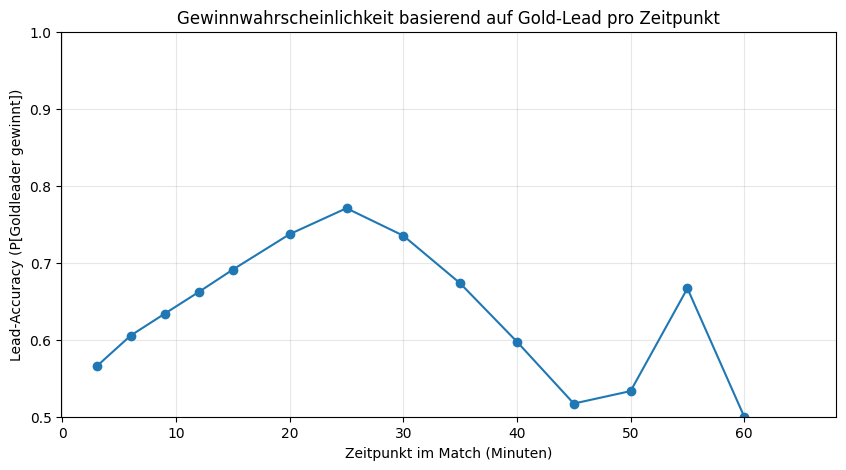

In [29]:
# x-Achse in Minuten statt Sekunden
lead_accuracy_by_time["timestamp_min"] = lead_accuracy_by_time["timestamp_s"] / 60

plt.figure(figsize=(10, 5))

#Wahrscheinlichkeit zu gewinnen, wenn man zu diesem Zeitpunkt Gold führt
plt.plot(
    lead_accuracy_by_time["timestamp_min"],
    lead_accuracy_by_time["lead_accuracy"],
    marker="o"
)

plt.title("Gewinnwahrscheinlichkeit basierend auf Gold-Lead pro Zeitpunkt")
plt.xlabel("Zeitpunkt im Match (Minuten)")
plt.ylabel("Lead-Accuracy (P[Goldleader gewinnt])")

plt.ylim(0.5, 1.0)
plt.grid(True, alpha=0.3)

plt.show()

PLOT Gewinnwahrscheinlichkeit & Match-Anzahl pro Zeitpunkt

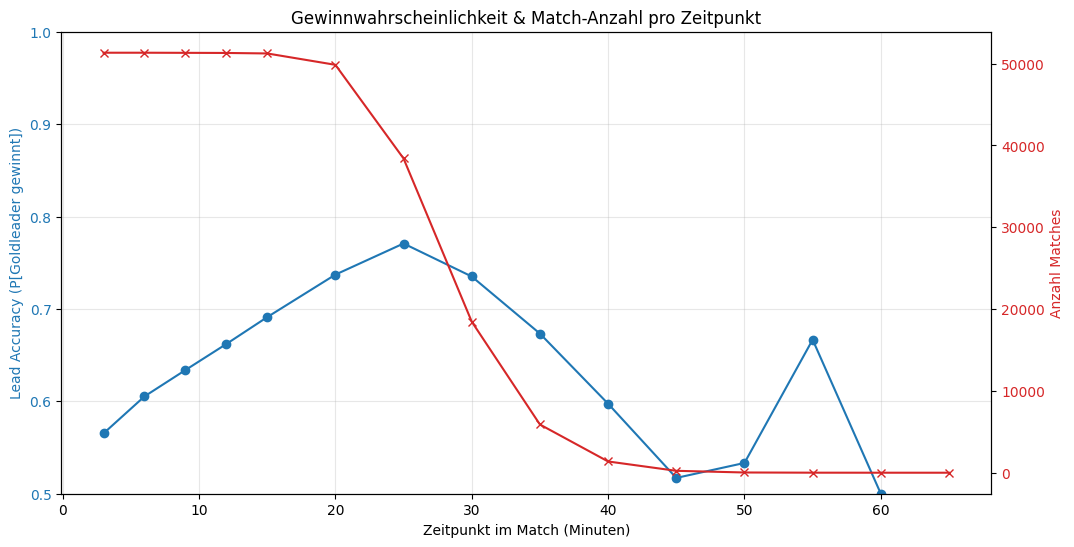

In [30]:
lead_accuracy_by_time["timestamp_min"] = lead_accuracy_by_time["timestamp_s"] / 60

plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(
    lead_accuracy_by_time["timestamp_min"],
    lead_accuracy_by_time["lead_accuracy"],
    color="tab:blue",
    marker="o",
    label="Gewinnwahrscheinlichkeit (Lead Accuracy)"
)
ax1.set_xlabel("Zeitpunkt im Match (Minuten)")
ax1.set_ylabel("Lead Accuracy (P[Goldleader gewinnt])", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0.5, 1.0)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(
    lead_accuracy_by_time["timestamp_min"],
    lead_accuracy_by_time["matchcount"],
    color="tab:red",
    marker="x",
    label="Anzahl der Matches"
)
ax2.set_ylabel("Anzahl Matches", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Gewinnwahrscheinlichkeit & Match-Anzahl pro Zeitpunkt")

plt.show()

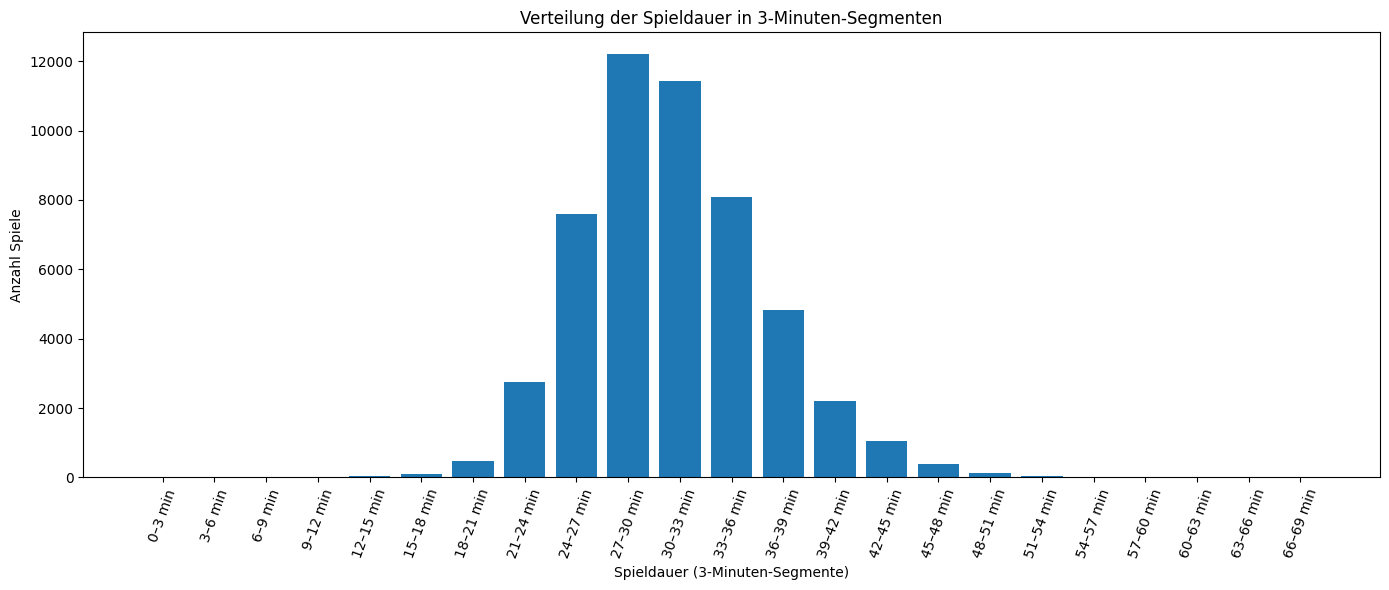

In [31]:
durations = df_info["duration_s"].astype(int)
bin_size = 180

max_duration = durations.max()
bins = np.arange(0, max_duration + bin_size, bin_size)
df_info["duration_bin"] = pd.cut(durations, bins=bins, right=False)

bin_counts = df_info["duration_bin"].value_counts().sort_index()

labels = [f"{int(left/60)}–{int(right/60)} min" for left, right in zip(bins[:-1], bins[1:])]


# --- Plot --- 
plt.figure(figsize=(14,6)) 
plt.bar(labels, bin_counts.values)

plt.xticks(rotation=70)
plt.xlabel("Spieldauer (3-Minuten-Segmente)")
plt.ylabel("Anzahl Spiele")
plt.title("Verteilung der Spieldauer in 3-Minuten-Segmenten")
plt.tight_layout()
plt.show()

